In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression



In [2]:
TR_PATH = '/content/drive/MyDrive/law_data/train.csv'
TS_PATH = '/content/drive/MyDrive/law_data/test.csv'
SUB_PATH = '/content/drive/MyDrive/law_data/sample_submission.csv'


In [3]:
train = pd.read_csv(TR_PATH)
test = pd.read_csv(TS_PATH)


In [4]:
train.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [6]:
vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X


In [7]:
X_train = get_vector(vectorizer, train, True)
Y_train = train["first_party_winner"]
X_test = get_vector(vectorizer, test, False)


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from lightgbm import LGBMClassifier

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['facts'])
vocab_size = len(tokenizer.word_index) + 1

# 텍스트를 시퀀스로 변환
X_train_sequence = tokenizer.texts_to_sequences(train['facts'])
X_test_sequence = tokenizer.texts_to_sequences(test['facts'])

# 시퀀스를 패딩하여 길이를 맞춤
max_len = 100  # 적절한 시퀀스 길이를 선택
X_train_padded = pad_sequences(X_train_sequence, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequence, maxlen=max_len, padding='post')

# RNN 모델 정의
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # First LSTM layer with return_sequences=True
model.add(LSTM(256, return_sequences=True))  # First LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True))  # First LSTM layer with return_sequences=True
model.add(LSTM(64))  # Second LSTM layer
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(X_train_padded, Y_train, epochs=100, batch_size=64)


Epoch 1/100
39/39 [==============================] - 15s 193ms/step - loss: 0.6464 - accuracy: 0.6598
Epoch 2/100
39/39 [==============================] - 5s 131ms/step - loss: 0.6262 - accuracy: 0.6695
Epoch 3/100
39/39 [==============================] - 6s 147ms/step - loss: 0.4236 - accuracy: 0.8128
Epoch 4/100
39/39 [==============================] - 4s 102ms/step - loss: 0.1812 - accuracy: 0.9338
Epoch 5/100
39/39 [==============================] - 2s 47ms/step - loss: 0.1025 - accuracy: 0.9677
Epoch 6/100
39/39 [==============================] - 2s 57ms/step - loss: 0.0469 - accuracy: 0.9847
Epoch 7/100
39/39 [==============================] - 4s 108ms/step - loss: 0.0245 - accuracy: 0.9927
Epoch 8/100
39/39 [==============================] - 2s 55ms/step - loss: 0.0122 - accuracy: 0.9972
Epoch 9/100
39/39 [==============================] - 2s 60ms/step - loss: 0.0362 - accuracy: 0.9875
Epoch 10/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0614 - accuracy: 

In [16]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

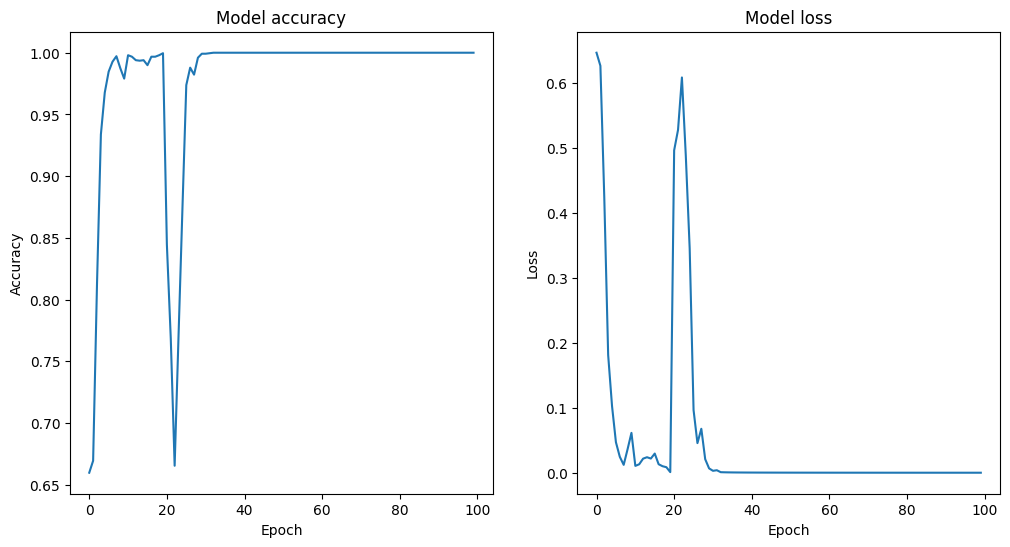

In [17]:
plot_history(history)

In [21]:
submit = pd.read_csv('/content/drive/MyDrive/law_data/sample_submission.csv')

# 예측
predictions = model.predict(X_test_padded)

# Threshold 설정
threshold = 0.5

# Threshold를 기준으로 이진 분류
binary_predictions = (predictions > threshold).astype(int)

# binary_predictions를 사용하여 예측 결과 확인
print(binary_predictions)

submit['first_party_winner'] = binary_predictions
submit.to_csv('./submit.csv', index=False)
print('Done')

39/39 [==============================] - 0s 10ms/step
[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
Done


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from lightgbm import LGBMClassifier

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['facts'])
vocab_size = len(tokenizer.word_index) + 1

# 텍스트를 시퀀스로 변환
X_train_sequence = tokenizer.texts_to_sequences(train['facts'])
X_test_sequence = tokenizer.texts_to_sequences(test['facts'])

# 시퀀스를 패딩하여 길이를 맞춤
max_len = 100  # 적절한 시퀀스 길이를 선택
X_train_padded = pad_sequences(X_train_sequence, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequence, maxlen=max_len, padding='post')

# RNN 모델 정의
# LightGBM 모델 초기화
model_LGBM = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary',
    metric='binary_logloss'
)

# 모델 훈련
history_LGBM = model_LGBM.fit(X_train_padded, Y_train)


[LightGBM] [Info] Number of positive: 1649, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2478, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665456 -> initscore=0.687704
[LightGBM] [Info] Start training from score 0.687704


In [24]:
submit = pd.read_csv('/content/drive/MyDrive/law_data/sample_submission.csv')

# 예측
predictions = history_LGBM.predict(X_test_padded)

# Threshold 설정
threshold = 0.5

# Threshold를 기준으로 이진 분류
binary_predictions = (predictions > threshold).astype(int)

# binary_predictions를 사용하여 예측 결과 확인
print(binary_predictions)

submit['first_party_winner'] = binary_predictions
submit.to_csv('./submit_GBM.csv', index=False)
print('Done')

[1 1 1 ... 1 1 1]
Done
